In [150]:
df = pd.read_csv('shop2_resto_v2.csv',encoding='latin1')

In [151]:
from xgboost import XGBRegressor

In [152]:
df.columns

Index(['month_idx', 'hour_idx', 'mday_idx', 'year_idx', 'temperature',
       'precipitation', 'snowfraction', 'sealevelpressure', 'winddirection',
       'windspeed', 'relativehumidity', 'sunshinetime', 'totalcloudcover',
       'lowclouds', 'midclouds', 'highclouds', 'wday_x', 'month', 'hour',
       'mday', 'year', 'timestamp', 'is_resto', 'month.1', 'hour.1', 'mday.1',
       'year.1', 'price', 'count', 'n_transactions', 'last_week_price',
       'last_month_price'],
      dtype='object')

In [184]:
features = ['precipitation', 'snowfraction', 'sealevelpressure', 'winddirection',
       'windspeed', 'relativehumidity', 'sunshinetime', 'totalcloudcover',
       'lowclouds', 'midclouds', 'highclouds', 'last_week_price','last_month_price', ] 

df[features] = df[features].fillna(0.)
features += [ 
         'mday', 'hour', 'wday_x'] 
X = df[ features ]
y = df['price']

In [185]:
# ?XGBRegressor

In [186]:
reg  = XGBRegressor(max_depth=10,n_estimators=300,subsample=0.8, base_score=y.mean(), random_state=1234)



In [187]:
from sklearn.model_selection import train_test_split

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=2345)

In [189]:
reg.fit(X_train,y_train)

XGBRegressor(base_score=390.1651928081383, booster='gbtree',
       colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=300, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=1234, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8)

In [190]:
reg.score(X_test,y_test)

0.8249757991527067

In [191]:
y_pred = reg.predict(X_test)

In [192]:
from sklearn.metrics import r2_score

In [193]:
r2_score(y_test,y_pred)

0.8249757991527067

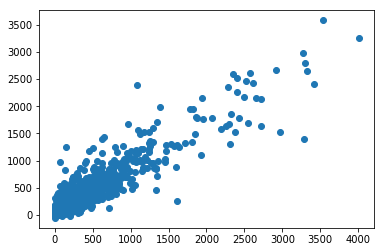

In [194]:
plt.scatter(y_test,y_pred)

In [195]:
list(zip(features, reg.feature_importances_))

[('precipitation', 0.038791455),
 ('snowfraction', 0.0014687188),
 ('sealevelpressure', 0.18534243),
 ('winddirection', 0.15056218),
 ('windspeed', 0.1395653),
 ('relativehumidity', 0.095935725),
 ('sunshinetime', 0.030966517),
 ('totalcloudcover', 0.018710736),
 ('lowclouds', 0.016489144),
 ('midclouds', 0.020907644),
 ('highclouds', 0.035113487),
 ('last_week_price', 0.1081915),
 ('last_month_price', 0.0),
 ('mday', 0.052404873),
 ('hour', 0.07405305),
 ('wday_x', 0.03149723)]

In [196]:
from sklearn.ensemble import GradientBoostingRegressor


In [197]:
qt025 = GradientBoostingRegressor(loss='quantile',alpha=0.25,subsample=0.8)
qt075 = GradientBoostingRegressor(loss='quantile',alpha=0.75,subsample=0.8)


In [198]:
qt025.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.25, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='quantile', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=0.8, verbose=0,
             warm_start=False)

In [200]:
qt075.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.75, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='quantile', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=0.8, verbose=0,
             warm_start=False)

In [201]:
y025_pred = qt025.predict(X_test)
y075_pred = qt025.predict(X_test)


In [209]:
print( (y_test < y025_pred).sum() / y_test.count() )
print( (y_test > y075_pred).sum() / y_test.count() )

0.2667928098391675
0.7332071901608326
